## **Table of Contents**
---
* [Introduction](#Introduction)
* [Line Coordinates](#Line-Coordinates)
* [Install YOLOv8 and ByteTrack](#Install-YOLOv8-ByteTrack)
* [Video Information Extraction](#Video-Information-Extraction)
* [Vehicle Count](#Vehicle-Count)
* [Usage](#Usage)
* [Detection on Single frame]()


# **Introduction**
---

In the exciting field of object tracking, we embark on a project to deploy the advanced deep learning models, YOLOv8 and ByteTrack, to track the number of vehicles entering and leaving a bustling highway. Our aim is to craft an efficient and reliable system that can perform real-time detection and tracking of vehicles, while simultaneously keeping count of their movements. These models have shown remarkable performance in object detection and tracking tasks, and we will leverage their strengths to develop a custom pipeline that ensures highly accurate and efficient vehicle tracking.

# **Line Coordinates**
---

If you want to draw a line in a desired location in the video, you'll need to obtain the coordinates for that line. One easy way to do this is by extracting a frame from the video and then using a website to get the coordinates.

1. **Extract a frame from the video.** You can use a video editor or a Python library like OpenCV or Supervision to extract a frame from the video.

2. **Go to the website [PolygoneZone](https://roboflow.github.io/polygonzone/](https://roboflow.github.io/polygonzone/).** This website allows you to easily draw a polygon on the image and get the coordinates for that polygon.

3. **Upload the extracted frame to the website.** Click on the "Choose File" button and select the extracted frame from your computer.

4. **Draw a line on the image.** Use the polygon drawing tool to draw a line in the desired location on the image.

5. **Get the line coordinates.** Once you have drawn the line, the website will display the coordinates for the line. These coordinates can be copied and used in your Python code to draw the line in the desired location in the video.

By following above given simple steps, you can easily obtain the coordinates for drawing a line in the desired location in the video using a website.

## Install YOLOv8 and ByteTrack



In [1]:
# Pip install method (recommended)
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.81 🚀 Python-3.9.12 torch-1.12.1+cu102 CPU
Setup complete ✅ (8 CPUs, 7.7 GB RAM, 309.6/376.9 GB disk)


In [20]:
#!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import sys
sys.path.append(f"/ByteTrack")

import supervision
import yolox
from ultralytics import YOLO
from IPython import display
display.clear_output()
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.video.dataclasses import VideoInfo
from tqdm.notebook import tqdm
from typing import List
import numpy as np
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

supervision.__version__: 0.1.0
yolox.__version__: 0.1.0


# Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"
model = YOLO(MODEL)
model.fuse()

In [30]:
# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# **Video Information Extraction**


In [33]:
##Select Paths of input video and output video

SOURCE_VIDEO_PATH=SOURCE_VIDEO_PATH="/home/niraj/projects/vehicle count/input/test.mp4"
TARGET_VIDEO_PATH = f"/home/niraj/projects/vehicle count/Results/output.mp4"
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=942)

# Detection on Single frame 


0: 384x640 11 cars, 1 bus, 2 trucks, 872.3ms
Speed: 0.7ms preprocess, 872.3ms inference, 63.9ms postprocess per image at shape (1, 3, 640, 640)


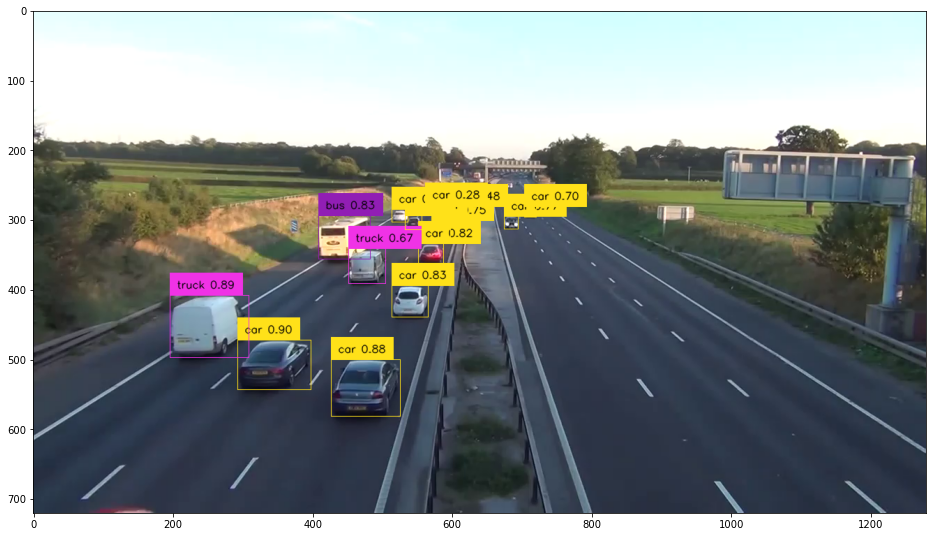

In [25]:

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [26]:
# settings
LINE_START = Point(330, 390)
LINE_END = Point(920, 386)

In [28]:
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/942 [00:00<?, ?it/s]


0: 384x640 11 cars, 1 bus, 2 trucks, 933.6ms
Speed: 0.9ms preprocess, 933.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 bus, 2 trucks, 961.9ms
Speed: 1.9ms preprocess, 961.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 bus, 2 trucks, 1033.7ms
Speed: 0.8ms preprocess, 1033.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 1 bus, 2 trucks, 967.5ms
Speed: 0.8ms preprocess, 967.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 bus, 2 trucks, 998.4ms
Speed: 2.2ms preprocess, 998.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 bus, 3 trucks, 996.3ms
Speed: 1.0ms preprocess, 996.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 1 bus, 2 trucks, 1080.3ms
Speed: 0.9ms preprocess, 1080.3ms inference, 1.2ms postprocess per image at shape (1, 3


0: 384x640 15 cars, 1 bus, 2 trucks, 923.3ms
Speed: 1.1ms preprocess, 923.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 1 truck, 915.6ms
Speed: 0.8ms preprocess, 915.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 2 trucks, 899.5ms
Speed: 1.2ms preprocess, 899.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 1 truck, 991.5ms
Speed: 2.1ms preprocess, 991.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 2 trucks, 933.7ms
Speed: 0.8ms preprocess, 933.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 2 trucks, 980.7ms
Speed: 0.8ms preprocess, 980.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 1 bus, 2 trucks, 930.8ms
Speed: 0.9ms preprocess, 930.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640,

Speed: 0.8ms preprocess, 903.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 3 trucks, 912.3ms
Speed: 1.1ms preprocess, 912.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 3 trucks, 1388.0ms
Speed: 1.0ms preprocess, 1388.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 2 trucks, 1249.3ms
Speed: 1.0ms preprocess, 1249.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 999.8ms
Speed: 0.7ms preprocess, 999.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 2 trucks, 915.4ms
Speed: 0.9ms preprocess, 915.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 977.7ms
Speed: 1.4ms preprocess, 977.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 964.0ms
Speed: 1.0ms preprocess, 964.0ms infe


0: 384x640 17 cars, 2 trucks, 894.9ms
Speed: 0.9ms preprocess, 894.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 trucks, 1030.6ms
Speed: 2.6ms preprocess, 1030.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 trucks, 942.9ms
Speed: 1.0ms preprocess, 942.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 trucks, 943.5ms
Speed: 0.8ms preprocess, 943.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 957.5ms
Speed: 0.9ms preprocess, 957.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 1384.1ms
Speed: 0.8ms preprocess, 1384.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 1001.7ms
Speed: 0.9ms preprocess, 1001.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 948.


0: 384x640 18 cars, 1 truck, 1046.3ms
Speed: 0.8ms preprocess, 1046.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 1 truck, 996.4ms
Speed: 2.3ms preprocess, 996.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 1 truck, 964.9ms
Speed: 0.9ms preprocess, 964.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 trucks, 978.4ms
Speed: 0.9ms preprocess, 978.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 trucks, 915.5ms
Speed: 1.8ms preprocess, 915.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 947.0ms
Speed: 0.9ms preprocess, 947.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 1173.9ms
Speed: 1.0ms preprocess, 1173.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 trucks, 1390.9ms



0: 384x640 13 cars, 2 trucks, 1083.5ms
Speed: 1.1ms preprocess, 1083.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 2 trucks, 1065.9ms
Speed: 1.1ms preprocess, 1065.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 2 trucks, 1005.1ms
Speed: 1.0ms preprocess, 1005.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 3 trucks, 985.4ms
Speed: 0.9ms preprocess, 985.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 3 trucks, 1145.4ms
Speed: 0.9ms preprocess, 1145.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 1019.5ms
Speed: 0.8ms preprocess, 1019.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 3 trucks, 1037.6ms
Speed: 0.9ms preprocess, 1037.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 3 trucks

Speed: 2.2ms preprocess, 949.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 992.3ms
Speed: 0.9ms preprocess, 992.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 976.1ms
Speed: 2.4ms preprocess, 976.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 2 trucks, 976.0ms
Speed: 1.1ms preprocess, 976.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 965.4ms
Speed: 1.0ms preprocess, 965.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 1018.7ms
Speed: 0.8ms preprocess, 1018.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 1 traffic light, 979.2ms
Speed: 0.8ms preprocess, 979.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 1 traffic light, 1023.7ms
Spee


0: 384x640 11 cars, 1 truck, 964.2ms
Speed: 0.8ms preprocess, 964.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 1 truck, 1070.5ms
Speed: 0.8ms preprocess, 1070.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 truck, 1100.8ms
Speed: 1.0ms preprocess, 1100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 1 truck, 1143.3ms
Speed: 0.7ms preprocess, 1143.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 1 truck, 1019.7ms
Speed: 1.0ms preprocess, 1019.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 1 truck, 1019.7ms
Speed: 1.0ms preprocess, 1019.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 1 truck, 961.6ms
Speed: 0.8ms preprocess, 961.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 2 trucks, 1020.6m

Speed: 1.0ms preprocess, 1113.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 1086.9ms
Speed: 1.0ms preprocess, 1086.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 966.4ms
Speed: 1.1ms preprocess, 966.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 2 trucks, 1088.8ms
Speed: 1.0ms preprocess, 1088.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 2 trucks, 980.3ms
Speed: 0.7ms preprocess, 980.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 3 trucks, 931.8ms
Speed: 0.7ms preprocess, 931.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 3 trucks, 1013.1ms
Speed: 1.2ms preprocess, 1013.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 3 trucks, 1025.3ms
Speed: 3.7ms preprocess, 1025.3ms

Speed: 0.8ms preprocess, 1142.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1078.7ms
Speed: 0.8ms preprocess, 1078.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1020.2ms
Speed: 1.1ms preprocess, 1020.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1102.2ms
Speed: 1.0ms preprocess, 1102.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 3 trucks, 1074.1ms
Speed: 1.1ms preprocess, 1074.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1120.1ms
Speed: 0.8ms preprocess, 1120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1080.4ms
Speed: 1.0ms preprocess, 1080.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 trucks, 1138.4ms
Speed: 1.1ms preprocess, 11


0: 384x640 15 cars, 5 trucks, 1068.1ms
Speed: 0.8ms preprocess, 1068.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 1005.1ms
Speed: 0.8ms preprocess, 1005.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 1123.9ms
Speed: 1.1ms preprocess, 1123.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 1130.7ms
Speed: 1.0ms preprocess, 1130.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 1149.8ms
Speed: 2.7ms preprocess, 1149.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 4 trucks, 1060.6ms
Speed: 0.8ms preprocess, 1060.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 4 trucks, 1062.5ms
Speed: 0.8ms preprocess, 1062.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 4 truc


0: 384x640 11 cars, 6 trucks, 1123.2ms
Speed: 0.8ms preprocess, 1123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 6 trucks, 1159.5ms
Speed: 1.3ms preprocess, 1159.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 5 trucks, 1189.3ms
Speed: 1.0ms preprocess, 1189.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 cars, 5 trucks, 1694.1ms
Speed: 0.9ms preprocess, 1694.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 12 cars, 5 trucks, 1412.7ms
Speed: 1.2ms preprocess, 1412.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 5 trucks, 1107.8ms
Speed: 1.3ms preprocess, 1107.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 6 trucks, 1239.3ms
Speed: 1.2ms preprocess, 1239.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 cars, 6 truc

Speed: 2.0ms preprocess, 1336.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 14 cars, 5 trucks, 1385.6ms
Speed: 0.9ms preprocess, 1385.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 997.2ms
Speed: 1.5ms preprocess, 997.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 993.2ms
Speed: 0.8ms preprocess, 993.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 5 trucks, 1098.3ms
Speed: 1.0ms preprocess, 1098.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 5 trucks, 1005.4ms
Speed: 0.8ms preprocess, 1005.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 5 trucks, 1024.7ms
Speed: 1.1ms preprocess, 1024.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 5 trucks, 1054.2ms
Speed: 0.9ms preprocess, 1054.2


0: 384x640 18 cars, 3 trucks, 1013.8ms
Speed: 2.2ms preprocess, 1013.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 3 trucks, 1109.2ms
Speed: 0.8ms preprocess, 1109.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 1001.1ms
Speed: 0.8ms preprocess, 1001.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 1013.8ms
Speed: 1.1ms preprocess, 1013.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 1001.6ms
Speed: 0.8ms preprocess, 1001.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 3 trucks, 1000.5ms
Speed: 1.2ms preprocess, 1000.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 1055.3ms
Speed: 0.9ms preprocess, 1055.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 3 truc

Speed: 0.8ms preprocess, 986.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 987.1ms
Speed: 1.7ms preprocess, 987.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 992.0ms
Speed: 0.9ms preprocess, 992.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 cars, 3 trucks, 995.4ms
Speed: 0.8ms preprocess, 995.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 cars, 3 trucks, 1016.5ms
Speed: 0.9ms preprocess, 1016.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 cars, 3 trucks, 1046.8ms
Speed: 0.8ms preprocess, 1046.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 cars, 3 trucks, 1071.6ms
Speed: 1.0ms preprocess, 1071.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 cars, 3 trucks, 1237.7ms
Speed: 0.8ms preprocess, 1237.7ms 


0: 384x640 21 cars, 2 trucks, 987.8ms
Speed: 0.8ms preprocess, 987.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 1007.2ms
Speed: 2.1ms preprocess, 1007.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 991.4ms
Speed: 2.0ms preprocess, 991.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 1007.7ms
Speed: 0.9ms preprocess, 1007.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 998.0ms
Speed: 0.9ms preprocess, 998.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 992.9ms
Speed: 0.9ms preprocess, 992.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 982.4ms
Speed: 0.8ms preprocess, 982.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 21 cars, 2 trucks, 987.9m

In [42]:
#!pip install moviepy
from moviepy.editor import VideoFileClip

videoClip = VideoFileClip("/home/niraj/projects/vehicle count/Results/output.mp4")

videoClip.write_gif("output.gif")


     |████████████████████████████████| 388 kB 394 kB/s eta 0:00:01
     |████████████████████████████████| 26.9 MB 111 kB/s eta 0:00:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=27329b47c1e35a68773879831fd333fb4b9df2f0ba486b8eab6235c85b63a046
  Stored in directory: /home/niraj/.cache/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
MoviePy - Building file output.gif with imageio.
